Задача - провести А/В тестирование с целью выявления эффективности рекламной стратегии. Большинство людей будут видеть рекламу (экспериментальная группа). А небольшая часть людей (контрольная группа) вместо этого увидит объявление государственной службы (PSA) (или ничего) точно такого же размера и в том же месте, где обычно находится реклама.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, shapiro, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import tt_ind_solve_power
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_and_clean_data(file_path):
    """
    Загрузка и очистка данных

    Parameters:
    -----------
    file_path : str
        Путь к файлу с данными

    Returns:
    --------
    pd.DataFrame
        Очищенный и подготовленный датафрейм
    """
    # Загрузка данных
    df = pd.read_csv(file_path, index_col=0)

    print("1. АНАЛИЗ СТРУКТУРЫ ДАННЫХ")
    print("\nИнформация о DataFrame:")
    print(df.info())

    print("\nОписательная статистика:")
    print(df.describe())

    print("\nПервые 5 строк данных:")
    print(df.head())

    # Анализ дубликатов
    duplicated_users = df[df['user id'].duplicated(keep=False)]
    print(f"\nКоличество дубликатов user_id: {len(duplicated_users)}")
    if len(duplicated_users) > 0:
        print("\nПримеры дубликатов:")
        print(duplicated_users)

    # Анализ пропусков
    missing_values = df.isnull().sum()
    print("\nКоличество пропущенных значений:")
    print(missing_values)

    if missing_values.sum() > 0:
        print("\nПроцент пропущенных значений:")
        print((missing_values / len(df) * 100).round(2))

    # Преобразование типов данных
    df['user id'] = df['user id'].astype('int64')
    df['converted'] = df['converted'].astype('bool')
    df['total ads'] = df['total ads'].astype('int64')
    df['most ads hour'] = df['most ads hour'].astype('int64')
    df['test group'] = df['test group'].astype('category')
    df['most ads day'] = df['most ads day'].astype('category')

    print("\nТипы данных после преобразования:")
    print(df.dtypes)

    # Проверка пользователей в обеих группах
    users_in_groups = df.groupby('user id', observed=False)['test group'].nunique()
    users_in_both = users_in_groups[users_in_groups > 1]

    if len(users_in_both) > 0:
        print(
            f"\nОбнаружено {len(users_in_both)} пользователей в обеих группах")
        print("Удаляем этих пользователей...")
        df = df[~df['user id'].isin(users_in_both.index)]

    # Анализ баланса групп
    group_sizes = df['test group'].value_counts()
    print("\nРаспределение по группам:")
    print(group_sizes)
    print("\nПроцентное соотношение групп:")
    print((group_sizes / len(df) * 100).round(2))

    return df

In [3]:
def calculate_group_metrics(df):
    """
    Расчет и визуализация ключевых метрик по группам

    Parameters:
    -----------
    df : pd.DataFrame
        Датафрейм с данными

    Returns:
    --------
    pd.DataFrame
        Датафрейм с метриками по группам
    """
    print("\n2. ПЕРВИЧНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")

    # Расчет метрик
    metrics = df.groupby('test group').agg({
        'user id': 'count',
        'converted': ['sum', 'mean'],
        'total ads': ['mean', 'std', 'sum']
    }).round(4)

    # Переименование колонок
    metrics.columns = [
        'Количество пользователей',
        'Количество конверсий',
        'Конверсия',
        'Среднее количество рекламы',
        'Стандартное отклонение рекламы',
        'Общее количество рекламы'
    ]

    # Добавление доверительных интервалов для конверсии
    for group in df['test group'].unique():
        group_data = df[df['test group'] == group]
        success = group_data['converted'].sum()
        total = len(group_data)
        ci_low, ci_high = proportion_confint(
            success, total, alpha=0.05, method='wilson')
        metrics.loc[group, 'CI конверсии (низ)'] = ci_low
        metrics.loc[group, 'CI конверсии (верх)'] = ci_high

    print("\nКлючевые метрики по группам:")
    print(metrics)

    # Визуализация метрик
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График конверсии с доверительными интервалами
    sns.barplot(x=metrics.index, y='Конверсия', data=metrics, ax=ax1)
    for i, group in enumerate(metrics.index):
        ax1.errorbar(i, metrics.loc[group, 'Конверсия'],
                     yerr=[[metrics.loc[group, 'Конверсия'] - metrics.loc[group, 'CI конверсии (низ)']],
                           [metrics.loc[group, 'CI конверсии (верх)'] - metrics.loc[group, 'Конверсия']]],
                     fmt='none', color='black', capsize=5)
    ax1.set_title('Конверсия по группам с 95% CI')
    ax1.set_ylabel('Конверсия')

    # График распределения рекламы
    sns.boxplot(x='test group', y='total ads', data=df, ax=ax2)
    ax2.set_title('Распределение количества рекламы по группам')
    ax2.set_ylabel('Количество рекламы')

    plt.tight_layout()
    plt.show()

    return metrics

In [4]:
def statistical_analysis(df):
    """
    Проведение статистического анализа

    Parameters:
    -----------
    df : pd.DataFrame
        Датафрейм с данными
    """
    print("\n3. СТАТИСТИЧЕСКИЙ АНАЛИЗ")

    # Проверка нормальности
    print("\nПроверка нормальности распределения количества рекламы:")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, group in enumerate(['ad', 'psa']):
        group_data = df[df['test group'] == group]['total ads']

        # Q-Q plot - исправленная версия
        fig_qq = plt.figure()
        stats.probplot(group_data, dist="norm", plot=plt)
        # Копируем график на нужную позицию
        fig_qq.canvas.draw()
        img = np.frombuffer(fig_qq.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig_qq.canvas.get_width_height()[::-1] + (3,))
        axes[0][i].imshow(img)
        axes[0][i].axis('off')
        axes[0][i].set_title(f"Q-Q plot для группы {group}")
        plt.close(fig_qq)

        # Гистограмма
        sns.histplot(group_data, ax=axes[1][i], kde=True)
        axes[1][i].set_title(f"Распределение рекламы для группы {group}")

        # Тест Шапиро-Уилка
        stat, p_value = shapiro(group_data)
        print(f"\nГруппа {group}:")
        print(f"Статистика Шапиро-Уилка: {stat:.4f}")
        print(f"p-значение: {p_value:.4f}")

    plt.tight_layout()
    plt.show()

    # Анализ конверсий
    print("\nАнализ конверсий (Z-тест):")
    group_data = df.groupby('test group',observed=False).agg({
        'converted': ['count', 'sum']
    })

    count_success = group_data['converted']['sum'].values
    count_total = group_data['converted']['count'].values

    stat, p_value = proportions_ztest(count_success, count_total)
    print(f"Z-статистика: {stat:.4f}")
    print(f"p-значение: {p_value:.4f}")

    # Непараметрический тест для количества рекламы
    print("\nАнализ количества рекламы (тест Манна-Уитни):")
    group_a = df[df['test group'] == 'ad']['total ads']
    group_b = df[df['test group'] == 'psa']['total ads']

    stat, p_value = mannwhitneyu(group_a, group_b, alternative='two-sided')
    print(f"U-статистика: {stat:.4f}")
    print(f"p-значение: {p_value:.4f}")

    # Визуализация распределений с доверительными интервалами
    plt.figure(figsize=(12, 6))

    # Создаем violin plot
    sns.violinplot(data=df, x='test group', y='total ads', inner='box')

    # Добавляем точечный график поверх
    sns.stripplot(data=df, x='test group', y='total ads',
                  color='red', alpha=0.3, size=4, jitter=0.2)

    # Добавляем средние значения и доверительные интервалы
    for i, group in enumerate(['ad', 'psa']):
        group_data = df[df['test group'] == group]['total ads']
        mean = group_data.mean()
        ci = stats.t.interval(0.95, len(group_data)-1,
                              loc=mean,
                              scale=stats.sem(group_data))

        # Добавляем среднее значение
        plt.hlines(y=mean, xmin=i-0.2, xmax=i+0.2,
                   color='green', linestyle='-', linewidth=2)

        # Добавляем доверительный интервал
        plt.vlines(x=i, ymin=ci[0], ymax=ci[1],
                   color='green', linestyle='--', linewidth=2)

        # Добавляем маркеры границ доверительного интервала
        plt.plot([i-0.1, i+0.1], [ci[0], ci[0]],
                 color='green', linewidth=2)
        plt.plot([i-0.1, i+0.1], [ci[1], ci[1]],
                 color='green', linewidth=2)

    plt.title(
        'Распределение количества рекламы по группам\n(с доверительными интервалами)')
    plt.xlabel('Группа')
    plt.ylabel('Количество рекламы')

    # Добавляем легенду
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='violet', alpha=0.5, label='Распределение'),
        Patch(facecolor='white', edgecolor='black', label='Box plot'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='None',
                   alpha=0.3, label='Наблюдения'),
        plt.Line2D([0], [0], color='green', linestyle='-',
                   label='Среднее значение'),
        plt.Line2D([0], [0], color='green', linestyle='--',
                   label='95% дов. интервал')
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1),
               loc='upper left')

    plt.tight_layout()
    plt.show()

In [5]:
def print_final_results(df, metrics):
    """
    Вывод итоговых результатов анализа с доверительными интервалами

    Parameters:
    -----------
    df : pd.DataFrame
        Датафрейм с данными
    metrics : pd.DataFrame
        Датафрейм с метриками по группам
    """
    print("\nИТОГОВЫЕ РЕЗУЛЬТАТЫ")
    print("=" * 50)

    # Вывод результатов по конверсии
    print("\nДоверительные интервалы для конверсий:")
    for group in df['test group'].unique():
        print(f"\nГруппа {group}:")
        print(f"Конверсия: {metrics.loc[group, 'Конверсия']:.4f}")
        print(f"95% CI: [{metrics.loc[group, 'CI конверсии (низ)']:.4f}, "
              f"{metrics.loc[group, 'CI конверсии (верх)']:.4f}]")

    # Расчет и вывод результатов по количеству рекламы
    print("\nДоверительные интервалы для количества рекламы:")
    for group in df['test group'].unique():
        group_data = df[df['test group'] == group]['total ads']
        mean = group_data.mean()
        ci = stats.t.interval(0.95, len(group_data)-1,
                            loc=mean,
                            scale=stats.sem(group_data))

        print(f"\nГруппа {group}:")
        print(f"Среднее: {mean:.4f}")
        print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

In [6]:
# Загрузка и очистка данных
df = load_and_clean_data('marketing_AB.csv')

1. АНАЛИЗ СТРУКТУРЫ ДАННЫХ

Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB
None

Описательная статистика:
            user id      total ads  most ads hour
count  5.881010e+05  588101.000000  588101.000000
mean   1.310692e+06      24.820876      14.469061
std    2.022260e+05      43.715181       4.834634
min    9.000000e+05       1.000000       0.000000
25%    1.143190e+06       4.000000      11.000000
50%    1.313725e+06      13.000000      14.000000
75%    1.484088e+06      27.000000      18.000000


Данные уже хорошо подготовлены для дальнейшего анализа, нет необходимости в предобработке(пропусков, дубликатов и пр. нет). test group и most ads day преобразованы в категориальный тип данных.


2. ПЕРВИЧНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ

Ключевые метрики по группам:
            Количество пользователей  Количество конверсий  Конверсия  \
test group                                                              
ad                            564577                 14423     0.0255   
psa                            23524                   420     0.0179   

            Среднее количество рекламы  Стандартное отклонение рекламы  \
test group                                                               
ad                             24.8234                         43.7505   
psa                            24.7611                         42.8607   

            Общее количество рекламы  CI конверсии (низ)  CI конверсии (верх)  
test group                                                                     
ad                          14014701            0.025138             0.025961  
psa                           582481            0.016239             0.019627  


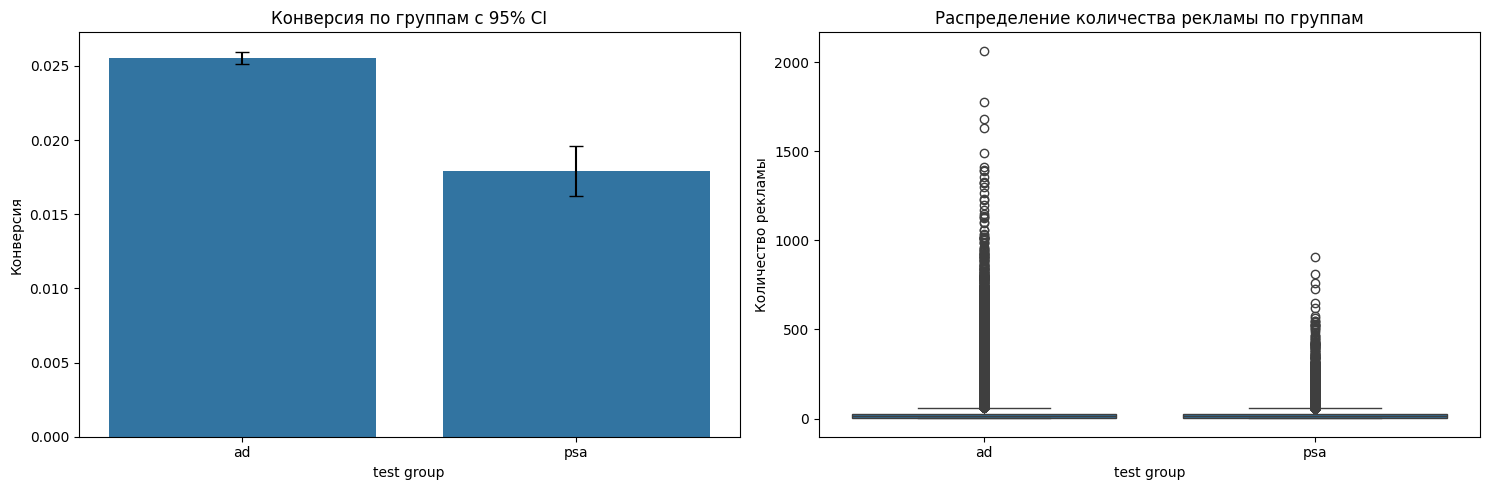

In [7]:
# Расчет метрик
metrics = calculate_group_metrics(df)

Распределение пользователей по группам сильно отличается (не сбалансировано), что необходимо учитывать в дальнейшем анализе и интерпретации результатов. Среднее количесто рекламы показанной в группах приблизително одинаковое, однако конверсия в группе ad (2.55%) значительно выше, чем в группе psa (1.79%).


3. СТАТИСТИЧЕСКИЙ АНАЛИЗ

Проверка нормальности распределения количества рекламы:

Группа ad:
Статистика Шапиро-Уилка: 0.4786
p-значение: 0.0000

Группа psa:
Статистика Шапиро-Уилка: 0.5159
p-значение: 0.0000


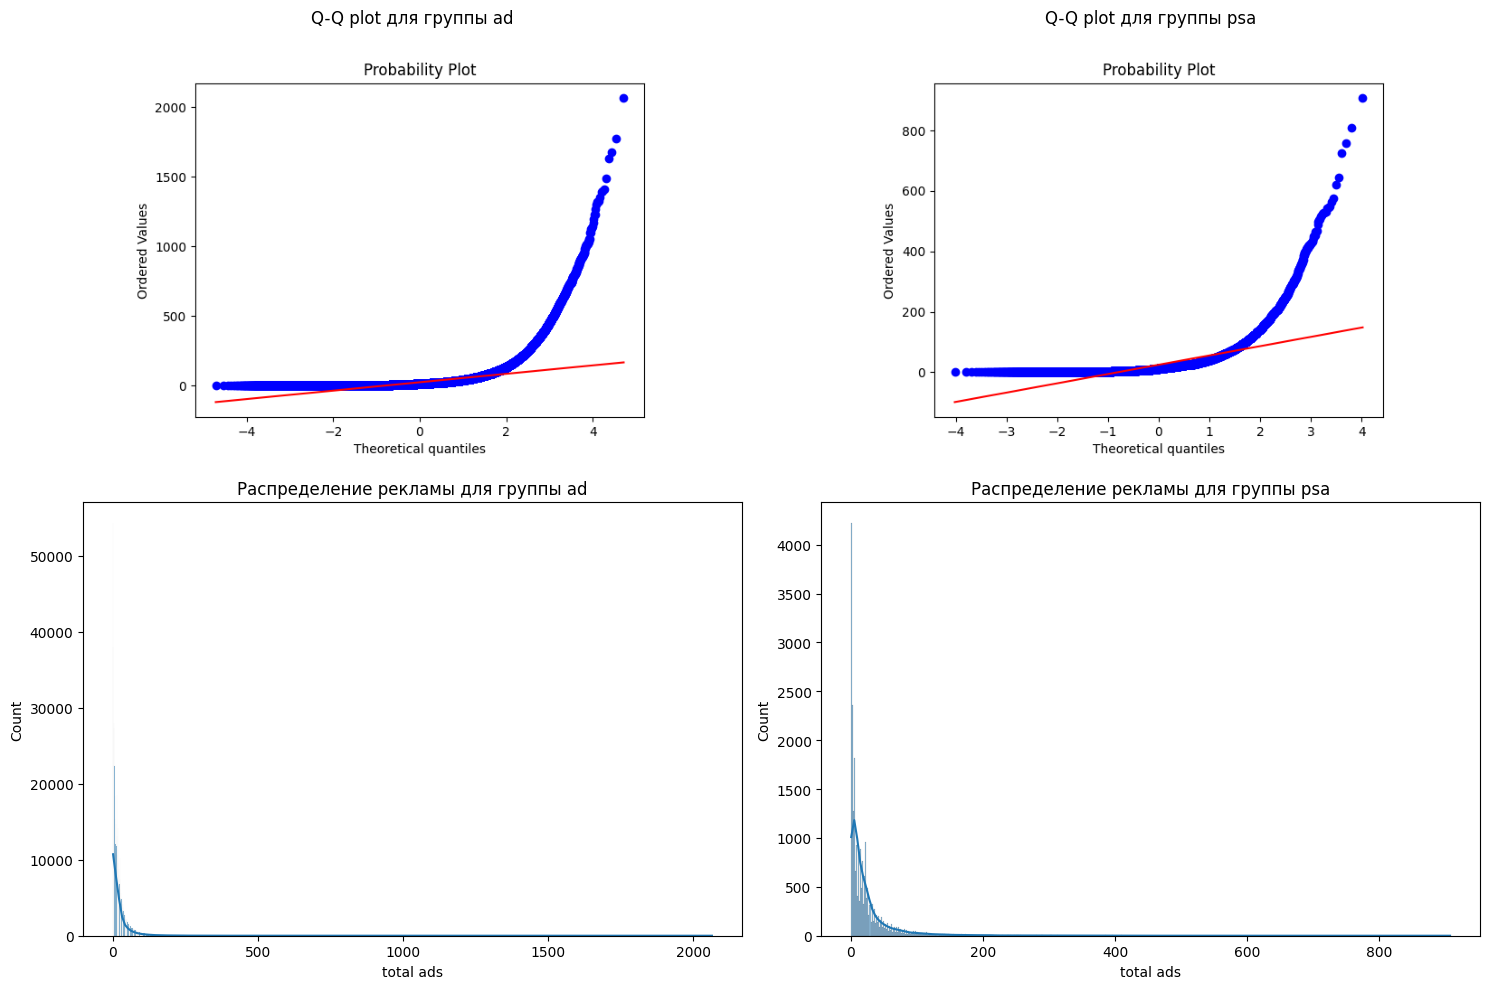


Анализ конверсий (Z-тест):
Z-статистика: 7.3701
p-значение: 0.0000

Анализ количества рекламы (тест Манна-Уитни):
U-статистика: 6808288222.0000
p-значение: 0.0000


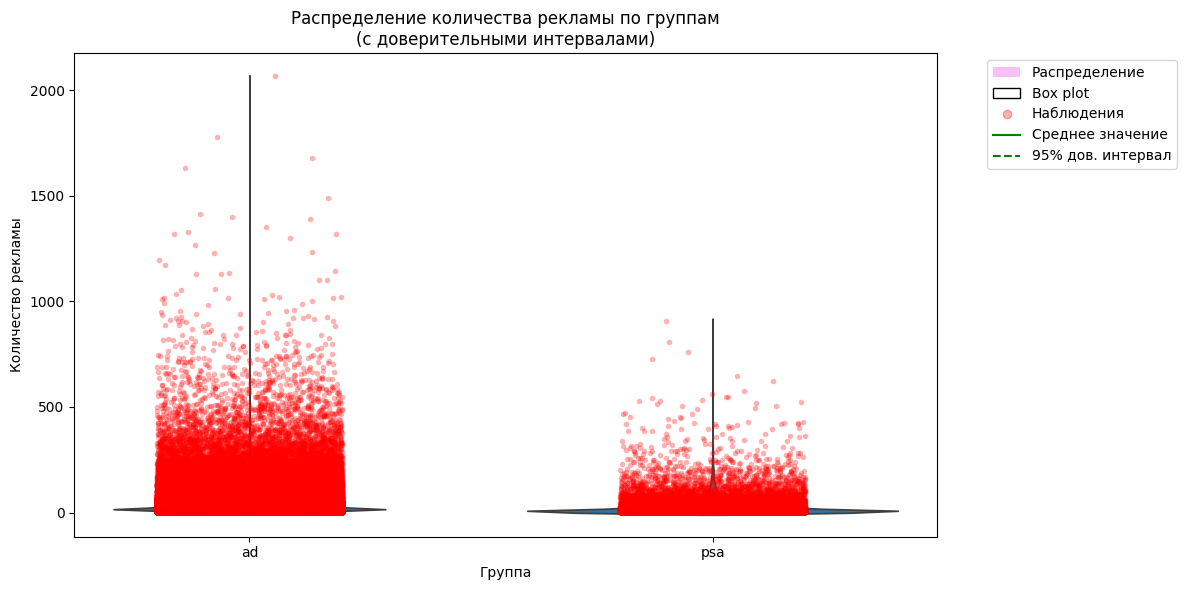

In [8]:
# Статистический анализ
statistical_analysis(df)



Статистика Шапиро-Уилка: 0.4786 при p-значение: 0.0000, следовательно распределение в группах сильно отклоняется от нормального.

Значение Z-статистики 7.3701 является очень высоким. Это означает, что разница в конверсии между группами ad и psa действительно значима и не является результатом случайных колебаний. p-value < 0.0001 и доверительные интервалы не пересекаются.


In [9]:
# Вывод итоговых результатов
print_final_results(df, metrics)


ИТОГОВЫЕ РЕЗУЛЬТАТЫ

Доверительные интервалы для конверсий:

Группа ad:
Конверсия: 0.0255
95% CI: [0.0251, 0.0260]

Группа psa:
Конверсия: 0.0179
95% CI: [0.0162, 0.0196]

Доверительные интервалы для количества рекламы:

Группа ad:
Среднее: 24.8234
95% CI: [24.7092, 24.9375]

Группа psa:
Среднее: 24.7611
95% CI: [24.2134, 25.3089]




Среднее количество показов рекламы в группах ad и psa очень близко друг к другу, т.е. обе группы получают примерно одинаковое количество показов. А конверсия в группе ad выше, чем в группе psa, доверительные интервалы не пересекаются, что говорит о статистически значимой разнице между группами. Рекламный контент в группе ad, вероятно, более эффективен в стимулировании конверсий, чем контент в группе psa.

НО несбалансированное распределение пользователей между группами (96% в группе ad и только 4% в группе psa) будет влиять на полученные результаты. Разница в конверсии может быть частично обусловлена этим дисбалансом. Меньший размер группы psa может преувеличивать различия, а данные группы ad будут более репрезентативными для общей выборки.

Вывод. Рекламный контент группы ad показывает более высокую конверсию, но интерпретация результатов все же требует осторожности. И следует пересмотреть дизайн эксперимента, сбалансировав группы.

 **Потенциальный доход:**  
 Чтобы рассчитать потенциальный доход, нужно знать: LTV клиента, стоимость рекламы и общий объем трафика.  
 Для примера рассчитаем доход для LTV=$100 на 1000 пользователей:  
     - С рекламой: 25.5 конверсий (2.55%) = $2,550 дохода.  
     - Без рекламы: 17.9 конверсий (1.79%) = $1,790 дохода.  
     - Дополнительный доход: **$760 на каждую 1000 пользователей**.
